# Perihelion Precession

The goal of this notebook is to simulate the impact of the curvature of the space-time on test particles in a gravitational potential. More specifically, we are going to approximate the geodesic equations for a test particle that has a bounded orbit to the center. We are describing the space-time with the Schwarzschild metric. To model a test particle in such a potential numerically, we first have to import some modules. Then, the GraviPy-module is going to be used again, in order to set up the geodesic equations. Afterwards, we will use SymPy to define some symbols. The NumPy-module is required for the numerical calculations. In order to solve the geodesic equation, there has to be used an algorithm, that solves differential equations. The ´integrate´ subpackage of the  SciPy-module provides many of these algorithms, for instance the current ´solv_ivp´ routine, which is used in this notebook. The gravitational constant $G$, the speed of light $c$ and the astronomical unit $\mathrm{AU}$ can be obtained from ´scipy.constants´ For the simulation and animation, matplotlib and  matplotlib.animation are going to be utilized. In this case, it is better to not use K3D, because there only need to be two dimensions and matplotlib provides a sufficient result. 

In [1]:
import gravipy.tensorial as gp
import sympy as sym
import numpy as np
from scipy.integrate import solve_ivp
from scipy.constants import G, c, au
import matplotlib.pyplot as plt
import matplotlib.animation as animation 

In our model, we consider a massive object with the mass $M$ in the center of our coordinate system and a test particle without any mass near to it. In general, this is not true, because a massive test particle like a planet would change the geometry of the spacetime. Nevertheless, it is applicable as an approximation for planets in the solar system, due to the small mass of the planets. If we consider for example our solar system, the mass of the sun makes up 99.86% of the whole mass of the solar system. Thus, the planets contribute barely any mass to the total mass of the considered system. Consequently, it is sufficient to model the problem with the Schwarzschild metric: $$
\mathrm{d}s^2 = (1-\frac{r_s}{r})c^2\mathrm{d}t^2-\frac{1}{1-\frac{r_s}{r}}\mathrm{d}r^2-r^2(\mathrm{d}\theta^2+\sin^2(\theta)\mathrm{d}\varphi^2)$$
with the spherical coordinates $r$, $\theta$, $\varphi$, the Schwarzschild radius $r_s = \frac{2GM}{c^2}$ and the time $t$ measured by an observer at infinity. To set up the geodesic equation, we define the variables with ´symbols´ and change the type to ´Coordinates´. Notice that for simplicity we are going to use the variable $ct$ instead of only $t$.

In [2]:
ct, r, phi = sym.symbols('ct, r, phi')
coords = gp.Coordinates('coords', [ct, r, phi])
rs = gp.Symbol('rs')

To ensure the conservation of angular momentum, the motion of the planet has to be in a plane. Hence one can set per instance $\theta = \frac{\pi}{2}$ and $\dot{\theta}=0$. This reduces the dimensionality of the metric tensor. Consequently, the line element can be written as: $$
\mathrm{d}s^2 = (1-\frac{r_s}{r})c^2\mathrm{d}t^2-\frac{1}{1-\frac{r_s}{r}}\mathrm{d}r^2-r^2\mathrm{d}\varphi^2$$
Now the metric $g_{\mu\nu}$ is printed as matrix:


In [3]:
Metric = sym.diag((1 - rs/r), -1/(1 - rs/r), -r**2*sym.sin(sym.pi/2)**2)
Metric

Matrix([
[1 - rs/r,             0,     0],
[       0, -1/(1 - rs/r),     0],
[       0,             0, -r**2]])

In order to simulate the movement of objects in the model of a solar system, we have to first determine and then solve the geodesic equation. This task can easily be done by symbolic computation, whereas it takes long calculations by hand. To display the differential equations in terms of variables with SymPy,  we transform them to a system of first order differential equations by the substitution $\frac{\mathrm{d}(ct)}{\mathrm{d}\tau}:=u$, $\frac{\mathrm{d}r}{\mathrm{d}\tau}:=v$ and $\frac{\mathrm{d}\varphi}{\mathrm{d}\tau}:=w$. 
Adjusting the dimensions, the ´DE´-function is changed for the four-dimensional case. Therefore, we set ´dim=3´ and add the missing auxiliary variable $w$. Then, a six-dimensional array for the result with symbols has to be created. Afterwards, we construct the sums with the double loop, adding the sums to the 3rd - 6th entry of ´result´. Accordingly, the index of the for loop in ´k´ has to be enhanced by three.

In [4]:
def DE(coords, G):
    u, v, w = sym.symbols("u v w")
    aux_coords = sym.Matrix([u, v, w])
    dim = 3
    result = sym.Matrix([u, v, w, 0., 0., 0.])

    for k in range(dim):
        s = 0
        for i in range(dim):
            for j in range(dim):
                fac = aux_coords[i]*aux_coords[j]
                s = s - G(-(k + 1), (i + 1), (j + 1))*fac
        result[k+3] = s
    return result

To get the differential equations, we calculate the Christoffel symbols with ´Christoffel´ and display all the entries. Then, we execute the ´DE´-function to see our equation.

In [5]:
g = gp.MetricTensor('g', coords, Metric)
Ga = gp.Christoffel('Ga', g)
Ga(-gp.All, gp.All, gp.All)

Matrix([[Matrix([
[                0, rs/(2*r*(r - rs)), 0],
[rs/(2*r*(r - rs)),                 0, 0],
[                0,                 0, 0]]), Matrix([
[-rs*(-r + rs)/(2*r**3),                              0,       0],
[                     0, rs*(-r + rs)/(2*r*(r - rs)**2),       0],
[                     0,                              0, -r + rs]]), Matrix([
[0,   0,   0],
[0,   0, 1/r],
[0, 1/r,   0]])]])

In [6]:
DE(coords, Ga)

Matrix([
[                                                                                 u],
[                                                                                 v],
[                                                                                 w],
[                                                              -rs*u*v/(r*(r - rs))],
[-w**2*(-r + rs) - rs*v**2*(-r + rs)/(2*r*(r - rs)**2) + rs*u**2*(-r + rs)/(2*r**3)],
[                                                                          -2*v*w/r]])

<a id = 'conservation'></a>
We can now read the output:
$$\left( \begin{array}{c}
	 c\dot{t} \\
	 \dot{r} \\
	 \dot{\varphi} \\
     \dot{u}\\
     \dot{v}\\
     \dot{w}\\
	 \end{array}
	 \right)=\left( \begin{array}{c}
     u \\
     v \\
     w \\
     \frac{-r_s}{r(r-r_s)}uv \\
     \frac{r_s(r_s-r)}{2r^3}u^2 -\frac{r_s}{2r(r_s-r)}v^2 - (r_s-r)w^2 \\
     -\frac{2}{r}vw \\
	 \end{array}
	 \right)$$
This equation can be used to solve the problem, but we did not do any preliminary considerations on the initial values. The following steps will need only the last three entries of the vector, because the firs three were only auxiliary variables. From these equations, it is possible to derive conservation laws. The used equations are as follows: 
$$\frac{\mathrm{d}^2(ct)}{\mathrm{d}\tau^2} = \frac{-r_s}{r(r-r_s)}\frac{\mathrm{d}(ct)}{\mathrm{d}\tau}\frac{\mathrm{d}r}{\mathrm{d}\tau}$$
$$\frac{\mathrm{d}^2r}{\mathrm{d}\tau^2} = \frac{r_s(r_s-r)}{2r^3}\left(\frac{\mathrm{d}(ct)}{\mathrm{d}\tau}\right)^2 -\frac{r_s}{2r(r_s-r)}\left(\frac{\mathrm{d}r}{\mathrm{d}\tau}\right)^2-(r_s-r)\left(\frac{d\varphi}{\mathrm{d}\tau}\right)^2$$
$$\frac{\mathrm{d}^2\varphi}{\mathrm{d}\tau^2} = -\frac{2}{r}\frac{\mathrm{d}r}{\mathrm{d}\tau}\frac{\mathrm{d}\varphi}{\mathrm{d}\tau}$$
From these equations, it is easy to derive the following conservation laws, applying the product and chain rule in reverse:
$$ \dot{\varphi} = \frac{L}{r^2} \text{ (conservation of angular momentum)}$$
$$ c\dot{t} = \frac{\Omega}{1-\frac{r_s}{r}}\text{ (conservation of $\Omega$)}$$ 
$$ \frac{1}{2}\dot{r}^2 +V_{\mathrm{eff}}(r) = \frac{\Omega^2-c^2}{2}:=E\text{ (conservation of energy)}$$
In these equations, similarly to the case of the Kepler problem, the [effective potential](https://en.wikipedia.org/wiki/Effective_potential) is used, although  this time we have a $r^{-3}$ term, modeling the relativistic effects: $$V_{\mathrm{eff}} (r)= -\frac{GMm}{r}+\frac{L^2m}{2r^2}-\frac{GMmL^2}{c^2r^3}$$ This potential can have different shapes, depending on the parameters $r_s$ (Mass of the object in the center) and the angular momentum $L$. The different terms in the potential for some $r$ can cancel each other out, so that it may lead to a maximum and minimum. After deriving and finding the zeros of the resulting quadratic equation, we obtain a rule for the angular momentum $L$. With $L>\sqrt{3}r_sc$ there is one maximum and one minimum. If $L$ is smaller, there are no roots of the parabola, hence the effective potential is monotonic. This means, the radius of a test particle is not limited. Consequently, there are no stable orbits. 

For further calculations, we first discuss the effective potential. Therefore, we set some parameters for our system and determine the Schwarzschild radius and angular momentum for stable orbits. In order to do that, $\sqrt{3}r_sc$ is multiplied by a factor ´fac´ bigger than one, so that a proper maximum and minimum is obtained.  

In [7]:
central_mass = 1.989e37
r_s = 2*G*central_mass/c**2
fac = 1.2
L = fac*3**0.5*r_s*c

Now we define a function for the effective potential ´V_eff´. Then, we plot the function using ´matplotlib´. The interval for $r$ has to be chosen in a way that the maximum and minimum of the resulting function can be seen properly. Multiplying the effective potential with $1e-15$, smaller values are obtained as well and the plot can be labeled by one label.      

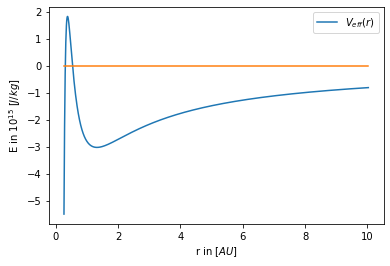

In [8]:
def V_eff(r, L, r_s):
    return -c**2*r_s/(2*r) + L**2/(2*r**2) - r_s*L**2/(2*r**3)

r = np.linspace(4e10, 1.5e12, 1000)
V = V_eff(r, L, r_s)*1e-15
r = r/au

plt.plot(r, V, label="$V_{eff}(r)$")
plt.legend()
plt.xlabel("r in $[AU$]")
plt.ylabel("E in $10^{15}$ $[J/kg]$")
plt.plot(r, 0*r)

The potential depends on the parameter ´fac´, so if you change these parameters, you can also change the possible orbits for the planet in the simulation.
The maximum and minimum can be found, solving a quadratic equation:
$$ r_{\mathrm{max}} = \frac{L^2}{r_sc^2} - \frac{L}{c}\sqrt{\frac{L^2}{c^2r_s^2} -3}$$
$$ r_{\mathrm{min}} = \frac{L^2}{r_sc^2} + \frac{L}{c}\sqrt{\frac{L^2}{c^2r_s^2} -3}$$
 Try different values for ´fac´ and plot the effective potential above, and explain the consequences for the possible orbits, looking at the position of maximum, minimum and shape of the graph.
1. _fac_ = 1
2. _fac_ = 1.4
3. _fac_ = 1.5
4. _fac_ = 0.9
5. _fac_ = 0
6. _fac_ = 100


If the energy of the test particle is higher than the maximum, it is going to crash into the center. If we want to solve the differential equation for the movement of the test particle, we have to provide initial values such as the starting position. Hence, it is interesting in which distance of the center we can find the maximum. Using the astronomical unit $\mathrm{AU}$ we can get a better understanding for the distances. To shorten the calculation of the extrema, it is useful to define a variable $\kappa = \frac{L^2}{r_sc^2}$.     

In [16]:
kappa = L**2/(r_s*c**2)
r_min = kappa + L/c*(kappa/r_s - 3)**0.5
r_max = kappa - L/c*(kappa/r_s - 3)**0.5
print("r_max = ", r_max/au, "AU")
print("r_min = ", r_min/au, "AU")

r_max =  0.3815076656430584 AU
r_min =  1.3245869465684956 AU


In the next step, we want to prepare the differential equations to simulate the orbit. Therefore, we use the [conservation of energy and angular momentum](#conservation) in the following form:$$
\dot{r} = \pm\sqrt{2\left(E - V_{\mathrm{eff}}(r)\right)}
$$$$ \dot{\varphi} = \frac{L}{r^2}
$$
In the first equation, one has to distinguish between the positive and negative case. The positive case describes the motion from the periastron (nearest position to the star) away towards the apastron (farthest position to the star). The negative case describes the way back from the apastron to the periastron.  The switching has to be handled manually. In the following, a function is defined with the name ´deriv´ : $$
deriv(l, r,\varphi) = \left( \begin{array}{c}
     \pm\sqrt{2\left(E - V_{\mathrm{eff}}(r)\right)}\\
     \frac{L}{r^2} \\
	 \end{array}
	 \right)
$$
The value $l$ stands for the parameter of the curve. This parameter is needed for the ODE-solver. Furthermore, we define the signum of the function. If $E-V_\mathrm{eff}(r)$ is zero, the differential equation for $\dot{r}$ has to change the sign. The motion between periastron and apastron is periodic, so the function will have to change its signum always when it reaches the nearest or farthest point to the star from $+1$ to $-1$ and then again to $+1$ and so on. To implement this, we set a global variable for the current signum, changing it when it is necessary. Numerical algorithms are only approximations. As a result, we use the norm of the difference $E-V_{eff}(r)$ in the returned vector to avoid a crash of the program for small errors.

In [10]:
signum = 1

def deriv(l, x, E, L):
    global signum
    r = x[0]
    phi = x[1]
    if abs(E - V_eff(r, L, r_s)) < 1e8:
        signum = -signum
    return np.array([signum*np.sqrt(2*abs(E - V_eff(r, L, r_s))), L/r**2])

With the [calculations](#conservation) that we did before, one can evaluate $E = V_\mathrm{eff}(r_{\mathrm{min}})$. Now, it is possible to set the inital values. In the periastron, we set $\varphi_0 = 0$. The solver has a problem with $\dot{r}=0$, because it is integrating step by step the velocity. Accordingly, it is not possible to start in the periastron. If we expand the radius in a Taylor series, we get :$$ r(\Delta t)\approx r(0) + \dot{r}(0)\Delta t +\frac{\ddot{r}(0)}{2}\Delta t^2$$ One can use the acceleration to find another starting point. After calculating this, we get:$$r(\Delta t) \approx r(0) \pm \frac{V'_{eff}(r(0))}{2}\Delta t^2$$Then we set up the startvector using for instance $\Delta t = 0.5$. To get better results with the Tayor series, the value for $\Delta t$ should be small. For the periastron, one can choose a value between $r_\mathrm{min}$ and $r_\mathrm{max}$. In this example, $r_\mathrm{min} = 0.7 \mathrm{AU}$ is used.


In [12]:
r_min = 0.7*au
phi0 = 0
deltat = 0.5


def dVdt(r, L, r_s):
    return (c**2)*r_s/(2*r**2) - L**2/(r**3) + 3*r_s*L**2/(2*r**4)
    
r0 = r_min - dVdt(r_min, L, r_s)/2*deltat**2
startvector = np.array([r0, phi0])

If we plot $f(r) = \sqrt{2\left(E - V_\mathrm{eff}(r)\right)} $, we can get an idea of the zeros, and with it an idea of the distance from the apastron to the center and the motion near to it. This holds true, because $f(r)$ describes the velocity in $r$ of the object. For the maximum or minimum (apastron, periastron) it applies $f(r_{\mathrm{max/min}})=0$. The lower bound of the interval is $r_0$. On the other hand, the upper bound has to be guessed or found numerically, because in general polynomial $\left(f(\frac{1}{r})\right)^2$ has no roots, and so $f(r)$ as well. We plot the graph to see some details of the movement.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


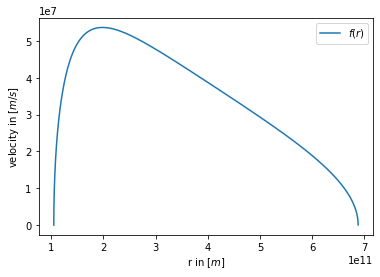

In [13]:
E = V_eff(r_min, L, r_s)
r = np.linspace(r_min, 8.5*r_min, 1000000)
plt.plot(r, np.sqrt(2*(E - V_eff(r, L, r_s))), label="$f (r)$")
plt.legend()
plt.xlabel("r in $[m]$")
plt.ylabel("velocity in $[m/s]$")
plt.show()

As you can see, the object has the largest acceleration near the periastron. The test particle is becoming slower, near the vertices of the ellipse. It also reaches its highest velocity near the periastron.

This kind of movement can also be observed with telescopes. Now we want to solve our differential equation. Therefore, we define a vector ´tspan´ with values of the curve parameter, for which an evaluation is desired. We are going to use the ´solve_ivp´-method from [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). We provide our function ´deriv´, the boundaries for the curve parameter, the start vector, the points of evaluation and the "LSODA" method. This solver automatically detects the stiffness of the problem and reacts properly. We set ´vectorized´ to ´True´ , because ´deriv´ has a vector format. Then, we extract the interesting information from the solution.

In [14]:
tspan = np.linspace(0, 200000, 300000)
solution = solve_ivp(lambda x, l: deriv(x, l, E, L), 
                     [tspan[0], tspan[-1]], startvector, 
                     t_eval=tspan, method="LSODA",
                     vectorized=True, max_step=0.1)
r = solution.y[0]
phi = solution.y[1]

In the last step, we want to visualize the result of our calculations with ´matplotlib´. Notice that our solution is in polar coordinates. Subsequently, they have to be transformed into Cartesian coordinates. Next, we plot our orbit with ´plt.plot()´. Further, we mark the center with a red dot and the starting position of the test particle with a blue dot. At the end, the result with is displayed with ´plt.show()´.

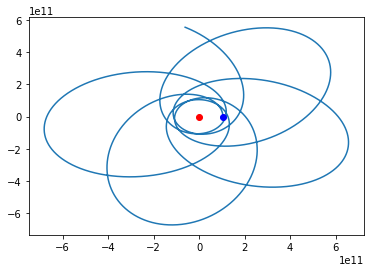

In [15]:
plt.plot(r*np.cos(phi), r*np.sin(phi))
plt.plot(0, 0, 'or')

plt.plot(startvector[0]*np.cos(startvector[1]),
         startvector[0]*np.sin(startvector[1]), 'ob')
plt.show()

Besides the shape of the orbit, it is also interesting to see the movement of the planet in the gravitational potential. Therefore, we create a simple animation with matplotlib. To display the result in an external window, one can set _%matplotlib qt_. How to create this animation, is shown in a tutorial with the title [A Growing Coil
](https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c)', by Parul Pandey.

In [ ]:
%matplotlib qt

fig = plt.figure() 
ax = plt.axes(xlim=(-8e11, 8e11), ylim=(-8e11, 10e11)) 
line, = ax.plot([], [], lw=2) 
planet, = ax.plot(0, 0, "ob")
star, = ax.plot(0, 0, "or")


def init(): 
    line.set_data([], []) 
    return line, 
 
xdata, ydata = [], [] 


def animate(i):
    global r
    global phi
    v = 300*i   
    x = r[v]*np.sin(phi)[v]
    y = r[v]*np.cos(phi)[v]
     
    xdata.append(x) 
    ydata.append(y) 
    planet.set_data(x, y)
    line.set_data(xdata, ydata) 
    return planet, line, 

plt.title('Movement of planet in solar system.') 
plt.axis("off")
 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=len(r), interval=0, blit=True) 